In [1]:
#matplotlib inline

import os
import json
import torch
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from utils.utils import unilateral_normalize, bilateral_normalize, sparse_mx_to_torch_sparse_tensor

In [2]:
# Load node ids
idx_train = pd.read_csv('data/train.csv')['Id'].values.ravel()
idx_test = pd.read_csv('data/test.csv')['Id'].values.ravel()
idx_allnodes = np.hstack([idx_train, idx_test])
len(idx_allnodes), len(idx_train), len(idx_test)
split_idx = int(len(idx_train) * 0.2)
idx_val = idx_train[split_idx:]
idx_train = idx_train[:split_idx]

In [3]:
# Build adjacency matrix
edges_tbl = pd.read_csv('data/edges.csv')
edges_tbl.head()

,Source,Target,Weight
0,13624,14622,2
1,2071,8198,1
2,4603,4021,1
3,7200,14485,1
4,1326,10355,3


In [4]:
row, col = edges_tbl['Source'].values, edges_tbl['Target'].values
weight = edges_tbl['Weight'].values
sp_adj = sp.csr_matrix((weight,(row, col)), shape=((len(idx_allnodes),)*2))
sp_adj = bilateral_normalize(sp_adj + sp.eye(sp_adj.shape[0]))
# sp_adj[13624, 14622], sp_adj[2071, 8198]
sp_adj[:,0]

<16466x1 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [5]:
# Load labels
raw_labels = pd.read_csv('data/train.csv').values
id2labels = {row[0]:row[1:].tolist() for row in raw_labels}
labels = np.zeros((len(idx_allnodes), raw_labels.shape[1] - 1))
labels[list(id2labels.keys())] = np.asarray(list(id2labels.values()))
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# Load node features
with open('data/node_info.json') as f:
    node_features = json.load(f)
features = {int(k):v for k,v in node_features.items()}
len(features)

16466

In [7]:
features

{0: {'PaperCount': 36,
  'CitationCountInAI': 874,
  'Affiliation': [{'AffiliationID': 608, 'PaperCount': 4}]},
 1: {'PaperCount': 40,
  'CitationCountInAI': 1301,
  'Affiliation': [{'AffiliationID': 1466, 'PaperCount': 1},
   {'AffiliationID': 3075, 'PaperCount': 9},
   {'AffiliationID': 1334, 'PaperCount': 10}]},
 2: {'PaperCount': 12,
  'CitationCountInAI': 8,
  'Affiliation': [{'AffiliationID': 1334, 'PaperCount': 5}]},
 3: {'PaperCount': 34,
  'CitationCountInAI': 40,
  'Affiliation': [{'AffiliationID': 2407, 'PaperCount': 10},
   {'AffiliationID': 2855, 'PaperCount': 5}]},
 4: {'PaperCount': 22,
  'CitationCountInAI': 22,
  'Affiliation': [{'AffiliationID': 1826, 'PaperCount': 2},
   {'AffiliationID': 1540, 'PaperCount': 1},
   {'AffiliationID': 432, 'PaperCount': 3},
   {'AffiliationID': 102, 'PaperCount': 1},
   {'AffiliationID': 2540, 'PaperCount': 2},
   {'AffiliationID': 4386, 'PaperCount': 2},
   {'AffiliationID': 3383, 'PaperCount': 1}]},
 5: {'PaperCount': 24,
  'Citation

In [8]:
# Convert features to sparse

# Get unique aff ids
affs = set()
for _, feat in features.items():
    for aff in feat['Affiliation']:
        affs.add(aff['AffiliationID'])
print(max(affs))

rows, cols, datas = [], [], []
for id, feat in features.items():
    rows.append(id)
    cols.append(0)
    datas.append(feat['PaperCount'])
    rows.append(id)
    cols.append(1)
    datas.append(feat['CitationCountInAI'])
    for aff in feat['Affiliation']:
        rows.append(id)
        cols.append(aff['AffiliationID'] + 2)
        datas.append(aff['PaperCount'])
print(len(rows), len(cols), len(datas))
print(max(cols), max(rows))
sp_features = sp.csr_matrix((datas, (rows, cols)), shape=(len(idx_allnodes), max(affs) + 3),  dtype=np.float32)
sp_features = unilateral_normalize(sp_features)
sp_features

4580
91590 91590 91590
4582 16465


<16466x4583 sparse matrix of type '<class 'numpy.float32'>'
	with 90955 stored elements in Compressed Sparse Row format>

In [9]:
graph = nx.DiGraph()
graph.add_nodes_from(sorted(idx_allnodes))
graph.add_weighted_edges_from(list(map(tuple, edges_tbl.values)))
graph.number_of_nodes(), graph.number_of_edges()

(16466, 364700)

916 0


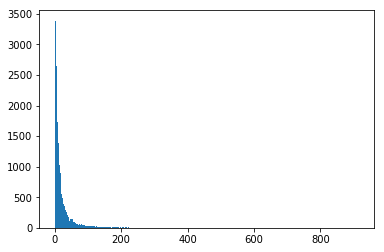

In [10]:
od = dict(graph.out_degree())
print(max(list(od.values())), min(list(od.values())))
_ = plt.hist(list(od.values()), bins=len(set(od.values())))

2079 0


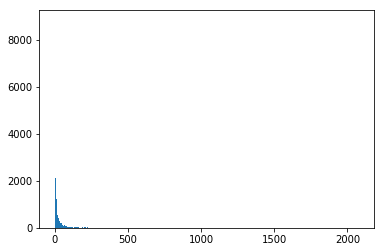

In [11]:
id = dict(graph.in_degree())
print(max(list(id.values())), min(list(id.values())))
_ = plt.hist(list(id.values()), bins=len(set(id.values())))

In [12]:
# from node2vec import Node2Vec

# # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
# node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# # Embed nodes
# model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

In [13]:
# # FILES
# EMBEDDING_FILENAME = 'data/embeddings.emb'
# EMBEDDING_MODEL_FILENAME = 'data/embeddings.model'

# # Save embeddings for later use
# model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# # Save model for later use
# model.save(EMBEDDING_MODEL_FILENAME)

In [14]:
# Look for most similar nodes
# nodeid = idx_train[6]
# print(nodeid, np.where(labels[nodeid])[0])
# for sim in model.wv.most_similar(str(nodeid)): # Output node names are always strings
#     print('{}: {}, score: {}'.format(sim[0], np.where(labels[int(sim[0])])[0], sim[1]))

In [15]:
# emb_features = np.vstack([model.wv[str(nodeid)] for nodeid in range(len(idx_allnodes))])
# emb_features.shape

In [16]:
features = sp_features.todense()
data = np.hstack([features, labels])
columns = ['PaperCount', 'CitationCountInAI']\
+ ['Affilation{}'.format(id) for id in range(4581)]\
+ ['Conf{}'.format(id) for id in range(8)]
data = pd.DataFrame(data=data, columns=columns)
data.head()

,PaperCount,CitationCountInAI,Affilation0,Affilation1,Affilation2,Affilation3,Affilation4,Affilation5,Affilation6,Affilation7,...,Affilation4579,Affilation4580,Conf0,Conf1,Conf2,Conf3,Conf4,Conf5,Conf6,Conf7
0,0.039387,0.956236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.029390,0.955915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.480000,0.320000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.382022,0.449438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.392857,0.392857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# cor = data.corr()
# cor.to_csv('corr.csv', index=False)

In [18]:
lbs = pd.read_csv('data/train.csv')
transfer_proba = np.zeros((8,8)).astype(np.float)
for i in range(8):
    for j in range(8):
        lb1 = 'Conf' + str(i)
        lb2 = 'Conf' + str(j)
        transfer_proba[i,j] = len(lbs[(lbs[lb1] == 1) & (lbs[lb2] == 1)]) / lbs[lb1].sum()
transfer_proba = pd.DataFrame(data=transfer_proba, columns=list(range(8)))
transfer_proba

,0,1,2,3,4,5,6,7
0,1.000000,0.096977,0.128463,0.094458,0.089421,0.037783,0.099496,0.372796
1,0.130508,1.000000,0.038983,0.159322,0.027119,0.254237,0.271186,0.118644
2,0.243437,0.054893,1.000000,0.131265,0.408115,0.035800,0.050119,0.186158
3,0.145349,0.182171,0.106589,1.000000,0.060078,0.065891,0.153101,0.112403
4,0.123264,0.027778,0.296875,0.053819,1.000000,0.019097,0.022569,0.097222
5,0.075000,0.375000,0.037500,0.085000,0.027500,1.000000,0.232500,0.070000
6,0.104636,0.211921,0.027815,0.104636,0.017219,0.123179,1.000000,0.080795
7,0.461778,0.109204,0.121685,0.090484,0.087363,0.043682,0.095164,1.000000


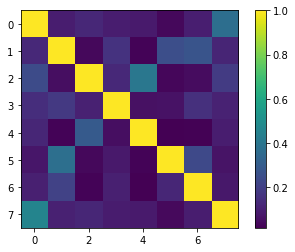

In [19]:
plt.imshow(transfer_proba.values)
plt.colorbar()

In [20]:
lb_corr = lbs.iloc[:,1:].corr()
lb_corr

,Conf0,Conf1,Conf2,Conf3,Conf4,Conf5,Conf6,Conf7
Conf0,1.000000,-0.120807,0.002070,-0.096507,-0.126855,-0.144401,-0.174021,0.253610
Conf1,-0.120807,1.000000,-0.123735,0.003375,-0.181764,0.189881,0.046582,-0.089693
Conf2,0.002070,-0.123735,1.000000,-0.026712,0.234382,-0.100134,-0.162729,-0.008195
Conf3,-0.096507,0.003375,-0.026712,1.000000,-0.130305,-0.073338,-0.078111,-0.089549
Conf4,-0.126855,-0.181764,0.234382,-0.130305,1.000000,-0.144290,-0.226407,-0.113305
Conf5,-0.144401,0.189881,-0.100134,-0.073338,-0.144290,1.000000,0.002853,-0.117069
Conf6,-0.174021,0.046582,-0.162729,-0.078111,-0.226407,0.002853,1.000000,-0.156847
Conf7,0.253610,-0.089693,-0.008195,-0.089549,-0.113305,-0.117069,-0.156847,1.000000


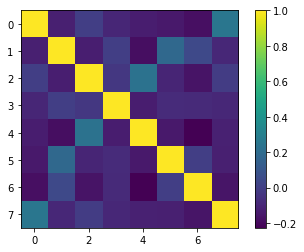

In [21]:
plt.imshow(lb_corr.values)
plt.colorbar()

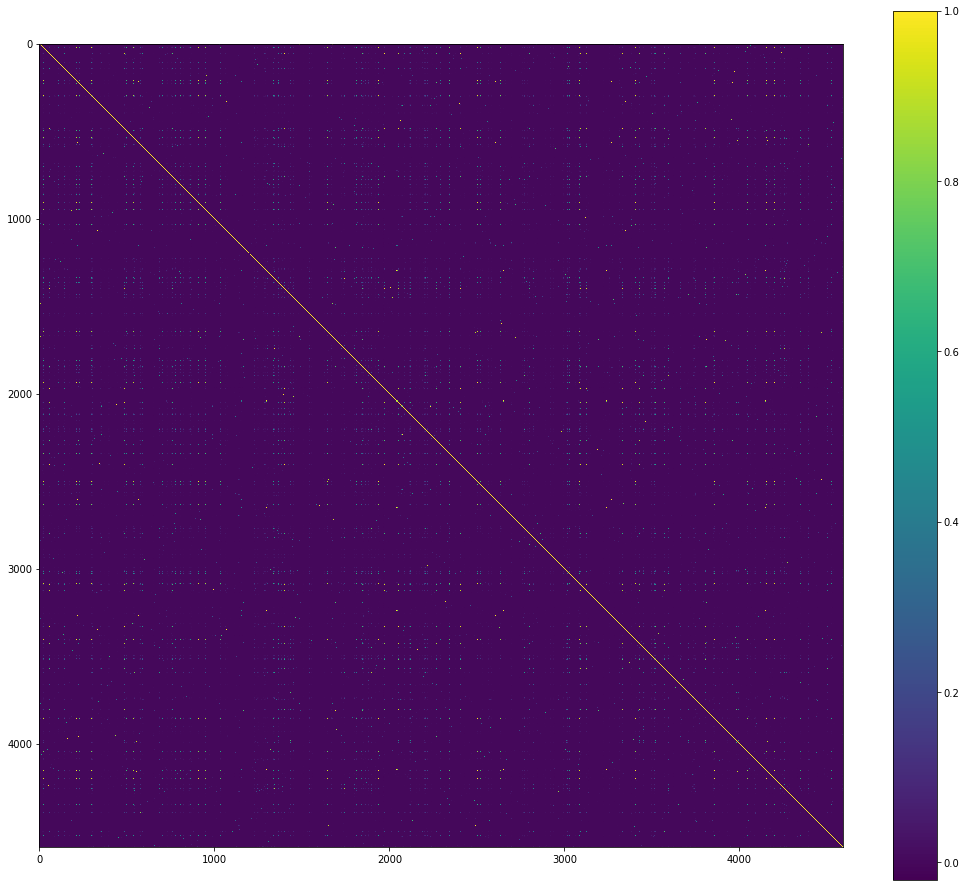

In [22]:
corr = pd.read_csv('data/corr.csv').values
fig = plt.figure(figsize=(18,16))
plt.imshow(corr)
plt.colorbar()

In [33]:
train_data = data.loc[idx_allnodes,:]
train_data.head()

,PaperCount,CitationCountInAI,Affilation0,Affilation1,Affilation2,Affilation3,Affilation4,Affilation5,Affilation6,Affilation7,...,Affilation4579,Affilation4580,Conf0,Conf1,Conf2,Conf3,Conf4,Conf5,Conf6,Conf7
6656,0.365079,0.476190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7200,0.304530,0.572987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
11669,0.384106,0.410596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15990,0.116473,0.825291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3915,0.391304,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [35]:
train_data.groupby('Affilation0').count()

,PaperCount,CitationCountInAI,Affilation1,Affilation2,Affilation3,Affilation4,Affilation5,Affilation6,Affilation7,Affilation8,...,Affilation4579,Affilation4580,Conf0,Conf1,Conf2,Conf3,Conf4,Conf5,Conf6,Conf7
Affilation0,,,,,,,,,,,,,,,,,,,,,
0.000000,16464,16464,16464,16464,16464,16464,16464,16464,16464,16464,...,16464,16464,16464,16464,16464,16464,16464,16464,16464,16464
0.001560,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.002128,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
